1.25.0-beta


/home/vincent/mambaforge/envs/meep/lib/python3.11/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/vincent/mambaforge/envs/meep/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/vincent/mambaforge/envs/meep/lib/python3.11/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/vincent/mambaforge/envs/meep/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


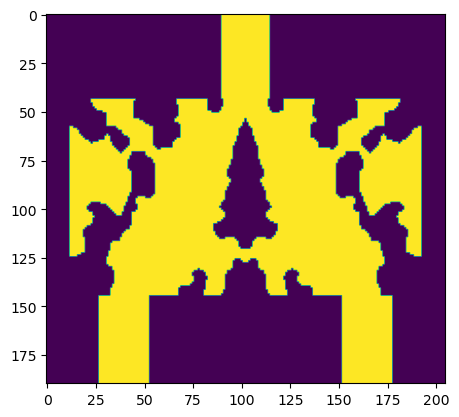

In [1]:
import meep as mp
print(mp.__version__)
import meep.adjoint as mpa
import numpy as np
import autograd.numpy as npa

from matplotlib import pyplot as plt
import h5py as hp
import os
import numpy as np

PATH = '~/scratch/nanophoto/lowfom/nodata/fields'
PATH = os.path.expanduser(PATH)
indices = np.load(os.path.join(PATH, 'indices.npy'))[0]
plt.imshow(indices)
plt.show()


In [2]:
zero_col = np.arange(indices.shape[1])[np.all(indices == indices[0], axis=0)]
zero_col

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11, 193,
       194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204])

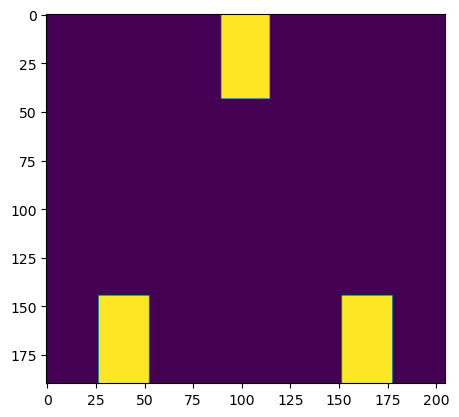

In [3]:
# Make channels file
indmax = indices.max()
indmin = indices.min()
top_lines = np.arange(indices.shape[0])[np.all(indices == indices[0], axis=1)]
bot_lines = np.arange(indices.shape[0])[np.all(indices == indices[-1], axis=1)]
channels = np.ones(indices.shape)*indmin
top = np.stack([indices[0]]*len(top_lines))
bot = np.stack([indices[-1]]*len(bot_lines))
channels[top_lines] = top
channels[bot_lines] = bot
plt.imshow(channels)
np.save(os.path.join(PATH, 'channels.npy'), channels)


In [4]:
top_channel_size = (len(top_lines), np.where(indices[0] == indmax)[0].shape[0]) 
print(top_channel_size)
lum_waveguide_len, lum_waveguide_wid = top_channel_size

(44, 25)


In [5]:
def trouver_centres(vecteur):
    vecteur = (vecteur - vecteur.min())/(vecteur.max() - vecteur.min())
    indices_uns = np.where(vecteur == 1)[0]
    changements = np.where(np.diff(indices_uns) != 1)[0]
    centre1 = indices_uns[0] + (indices_uns[changements[0]] - indices_uns[0]) // 2
    centre2 = indices_uns[changements[0] + 1] + (indices_uns[-1] - indices_uns[changements[0] + 1]) // 2
    return centre1, centre2

In [6]:
c1, c2 = trouver_centres(np.array([0,1,1,1,0,1,1,1,1,1,0]))
assert c1 == 2 and c2 == 7

In [7]:
centre1, centre2 = trouver_centres(indices[-1])
centre1, centre2

(39, 164)

Attention, les array d'indices que Lumerical construit a partir des images.npy sont modifiés un peu par rapport à l'original. Les modifications apparaissent à la frontière entre les deux matériaux et le long de 2 lignes centrales parallèles au guide de la source. Même pour des images générées par treesearch qui contiennent seulement 2 valeurs, environ 70 valeurs intermédiaires apparaissent dans les fichiers d'indices de Lumerical. Les défauts sont minimes et impossibles à voir sur une image (la différence des valeurs est parfois de l'ordre de 1e-16)

In [8]:
np.unique(indices).shape

(69,)

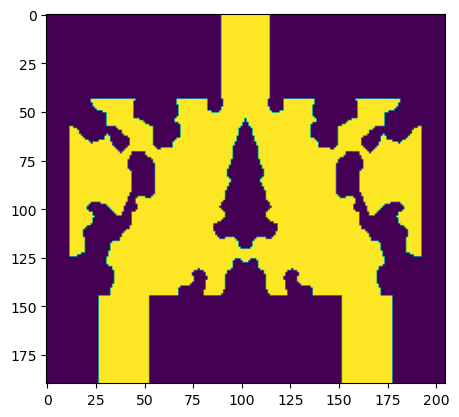

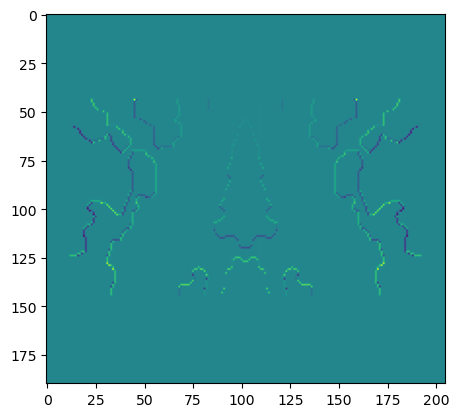

In [9]:
def double_with_mirror(image):
    channels = '~/scratch/nanophoto/lowfom/nodata/fields/channels.npy'
    channels = np.load(os.path.expanduser(channels))
    mirrored_image = np.fliplr(image)  # Crée l'image miroir
    doubled_image = np.concatenate((mirrored_image[:, :-1], image), axis=1)
    return doubled_image

def get_channels():
    return np.load(os.path.join(PATH, 'channels.npy'))

def double_and_add_channels(image):
    double = double_with_mirror(image)
    full_device = get_channels()
    full_device[44: 145, 12:193] = double
    return full_device

def set_experiment_indices(image):
    channels = get_channels()
    indmin = channels.min()
    indmax = channels.max()
    assert image.min() == 0 and image.max() == 1
    image = image*(indmax - indmin) + indmin
    return image

def normalise(image):
    image = (image - image.min()) / (image.max() - image.min())
    return image

    
image = np.load(os.path.join(PATH, 'images.npy'))[0]
image = set_experiment_indices(image)
channels = get_channels()
double = double_with_mirror(image)
full = double_and_add_channels(image)
plt.imshow(full)
plt.show()
plt.imshow(full-indices)

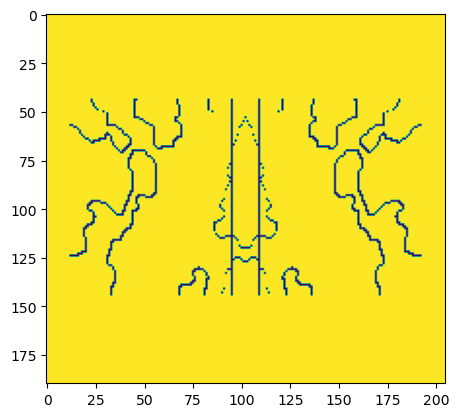

In [10]:
plt.imshow(np.isin(indices, [1.44, 2.8]))


## Basic environment setup

In [11]:
import pint
ur = pint.UnitRegistry()
lum_waveguide_len = lum_waveguide_len*ur.pixel
lum_waveguide_wid = lum_waveguide_wid*ur.pixel

In [12]:
# Lumerical experiment setup
# Dimensions definition
# < Length of the device (in nm). Longer devices typically lead to better performance
size_x = 2000*ur.nanometer
delta_x = 20*(ur.nanometer/ur.pixels)  # < Size of a pixel along x-axis (in nm)
# < Since we use symmetry, this is only have the extent along the y-axis (in nm)
size_y = 1800*ur.nanometer
delta_y = delta_x  # < Size of a pixel along y-axis (in nm)
# < Radius of the smoothing filter which removes small features and sharp corners (in nm)
filter_R = 200*ur.nanometer
# < Effective permittivity for a Silicon waveguide with a thickness of 220nm
eps_max = 2.8 ** 2
eps_min = 1.44 ** 2  # < Permittivity of the SiO2 cladding
x_points = (int((size_x / delta_x).magnitude)*ur.pixel + 1*ur.pixel)
y_points = (int((size_y / delta_y).magnitude)*ur.pixel + 1*ur.pixel)
x_pos = np.linspace(-size_x.magnitude / 2, size_x.magnitude / 2, x_points.magnitude) * 1e-9
y_pos = np.linspace(0, size_y.magnitude, y_points.magnitude) * 1e-9
lum_source_wavelength = 1550*ur.nanometer

In [13]:
c1, c2 = trouver_centres(indices[-1])
lum_arm_sep = (c2 - c1)*ur.pixel
print(lum_arm_sep)

125 pixel


In [14]:
seed = 240
np.random.seed(seed)
mp.verbosity(0)
Si = mp.Medium(index=2.88) # Effective permittivity for a Silicon waveguide with a thickness of 220nm
SiO2 = mp.Medium(index=1.44)
delta = delta_x.to(ur.micrometers/ur.pixel) #(0.02)*ur.micrometers  size of a pixel (in μm) 20 nm in lumerical exp
# resolution = 20 # (pixels/μm)
resolution = 1/delta # pixels/μm
waveguide_width = (delta_y * lum_waveguide_wid).to(ur.micrometer) #0.5 # (μm)
design_region_width = size_x.to(ur.micrometer)  + delta*ur.pixel # (μm)
design_region_height = (2*size_y).to(ur.micrometer) + delta*ur.pixel # (μm)
arm_separation = (lum_arm_sep*delta_y).to(ur.micrometer) #1.0  (μm) distance between arms center to center
waveguide_length = (lum_waveguide_len*delta).to(ur.micrometer) #0.5  (μm)
pml_size = 1.0 # (μm)


In [15]:
from icecream import ic
ic(resolution, waveguide_length, waveguide_width, design_region_height, design_region_width, arm_separation)

ic| resolution: <Quantity(50.0, 'pixel / micrometer')>
    waveguide_length: <Quantity(0.88, 'micrometer')>
    waveguide_width: <Quantity(0.5, 'micrometer')>
    design_region_height: <Quantity(3.62, 'micrometer')>
    design_region_width: <Quantity(2.02, 'micrometer')>
    arm_separation: <Quantity(2.5, 'micrometer')>


(<Quantity(50.0, 'pixel / micrometer')>,
 <Quantity(0.88, 'micrometer')>,
 <Quantity(0.5, 'micrometer')>,
 <Quantity(3.62, 'micrometer')>,
 <Quantity(2.02, 'micrometer')>,
 <Quantity(2.5, 'micrometer')>)

In [16]:
delta = delta.magnitude
resolution = resolution.magnitude
waveguide_width = waveguide_width.magnitude
design_region_width = design_region_width.magnitude
design_region_height = design_region_height.magnitude
arm_separation = arm_separation.magnitude
waveguide_length = waveguide_length.magnitude

## Design variable setup

In [17]:
minimum_length = 0.09 # (μm)
eta_e = 0.75
filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length,eta_e) # (μm)
eta_i = 0.5
eta_d = 1-eta_e
design_region_resolution = int(resolution) #int(4*resolution) # (pixels/μm)
frequencies = 1/np.linspace(1.5,1.6,5) # (1/μm)

Nx = int(design_region_resolution*design_region_width)
Ny = int(design_region_resolution*design_region_height)

design_variables = mp.MaterialGrid(mp.Vector3(Nx,Ny),SiO2,Si)
design_region = mpa.DesignRegion(design_variables,
    volume=mp.Volume(center=mp.Vector3(), size=mp.Vector3(design_region_width, design_region_height)))

Nx, Ny

(101, 181)

## Simulation Setup

To have the same polarization as the lumerical experiment (fields have Ex, Ey and Hz components), peterropac on the github discussion suggests to use eig_parity=mp.ODD_Y but the fields have Ez, Hx, Hy components. Yuri thinks we need eig_parity=mp.EVEN_Z. mp.EVEN_Z has the right polarity (fields have Ex, Ey and Hz components) but the fields dont look the same as the lumerical computed fields.

In [18]:
Sx = 2*pml_size + 2*waveguide_length + design_region_width # cell size in X
Sy = 2*pml_size + design_region_height + 0.5 # cell size in Y
cell_size = mp.Vector3(Sx,Sy)

pml_layers = [mp.PML(pml_size)]

fcen = (1/lum_source_wavelength.to(ur.micrometer)).magnitude #1/1.55
width = 0.2
fwidth = width * fcen
source_center  = [-Sx/2 + pml_size + waveguide_length/3,0,0]
# source_center  = [-Sx/2 + pml_size - waveguide_length,0,0]
source_size = mp.Vector3(0,3*waveguide_width, 0) #mp.Vector3(0,2,0)
kpoint = mp.Vector3(1,0,0)
src = mp.GaussianSource(frequency=fcen,fwidth=fwidth)
source = [mp.EigenModeSource(src,
                            eig_band=1,
                            direction=mp.NO_DIRECTION,
                            eig_kpoint=kpoint,
                            size=source_size,
                            center=source_center,
                            eig_parity=mp.EVEN_Z+mp.ODD_Y)]


geometry = [
    mp.Block(center=mp.Vector3(x=-Sx/4), material=Si, size=mp.Vector3(Sx/2+1, waveguide_width, 0)), # left waveguide
    mp.Block(center=mp.Vector3(x=Sx/4, y=arm_separation/2), material=Si, size=mp.Vector3(Sx/2+1, waveguide_width, 0)), # top right waveguide
    mp.Block(center=mp.Vector3(x=Sx/4, y=-arm_separation/2), material=Si, size=mp.Vector3(Sx/2+1, waveguide_width, 0)), # bottom right waveguide
    mp.Block(center=design_region.center, size=design_region.size, material=design_variables)
]

sim = mp.Simulation(cell_size=cell_size,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=source,
                    #symmetries=[mp.Mirror(direction=mp.Y)],
                    default_material=SiO2,
                    resolution=resolution)

## Design parameter mapping

In [19]:
def mapping(x,eta,beta):
    # eta in [0,1], skews the distribution towards one material or the other?
    # higher beta makes design more binarized
    x = (npa.fliplr(x.reshape(Nx,Ny)) + x.reshape(Nx,Ny))/2 # up-down symmetry
    # filter
    filtered_field = mpa.conic_filter(x,
        filter_radius,design_region_width,design_region_height,design_region_resolution)
    # projection
    projected_field = mpa.tanh_projection(filtered_field,beta,eta)
    # interpolate to actual materials
    return projected_field.flatten()

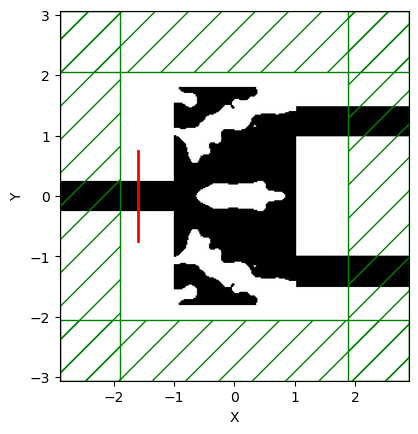

In [20]:
PATH = os.path.expanduser('~/scratch/nanophoto/lowfom/nodata/fields/')
# PATH = os.path.expanduser('~/scratch/nanophoto/highfom/')
image_idx = 1
image = np.load(os.path.join(PATH, 'images.npy'))[image_idx]
idx_map = double_with_mirror(image)
idx_map = normalise(idx_map)
index_map = mapping(idx_map, 0.5, 256)

design_region.update_design_parameters(index_map)

sim.plot2D()
plt.show()

<Axes: xlabel='X', ylabel='Y'>

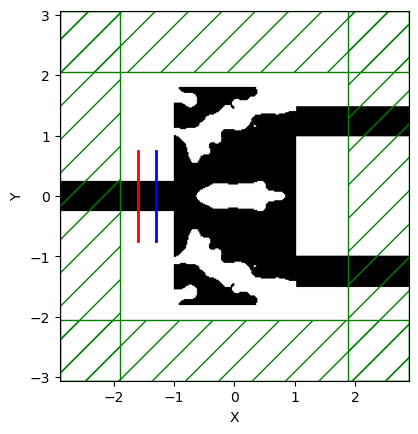

In [21]:
def get_sim_coeffs_from_flux_region(sim, fluxregion):
    sim.reset_meep()
    flux = sim.add_flux(fcen, 0, 1, fluxregion)
    # breakpoint()
    mon_pt = mp.Vector3(*source_center)
    sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, mon_pt,
                                                            1e-9))
    res = sim.get_eigenmode_coefficients(flux, [1])#,
                                        #  eig_parity=mp.ODD_Z + mp.EVEN_Y)
    coeffs = res.alpha
    accumulated_flux_spectrum = mp.get_fluxes(flux)
    return coeffs, accumulated_flux_spectrum


# Get incident flux coefficients
# source_center = [-Sx/2 + pml_size + waveguide_length/3, 0, 0]
mon_pt = mp.Vector3(x=-Sx/2 + pml_size + 2*waveguide_length/3)
monsize = mp.Vector3(y=3*waveguide_width)
fluxregion = mp.FluxRegion(center=mon_pt, size=monsize)
source_coeffs, source_flux_spectrum = get_sim_coeffs_from_flux_region(sim, fluxregion)
sim.plot2D()

<Axes: xlabel='X', ylabel='Y'>

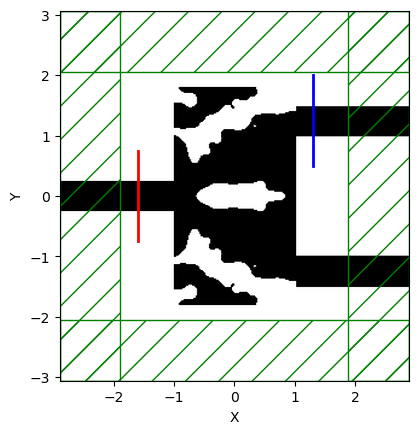

In [22]:
# Get top output flux coefficients
topmoncenter = mp.Vector3(Sx/2 - pml_size - 2*waveguide_length/3, arm_separation/2, 0)
topfluxregion = mp.FluxRegion(topmoncenter, monsize)
top_coeffs, top_flux_spectrum = get_sim_coeffs_from_flux_region(sim, topfluxregion)
sim.plot2D()

In [23]:
# # Get bot output flux coeffs
# botmoncenter = mp.Vector3(Sx/2 - pml_size - 2*waveguide_length / 3,
#                     -arm_separation/2, 0)
# botfluxregion = mp.FluxRegion(botmoncenter, monsize)
# bot_mon = sim.add_mode_monitor(fcen, 0, 1, botfluxregion)
# bot_coeffs, bot_flux_spectrum = get_sim_coeffs_from_flux_region(sim, botfluxregion)
# sim.plot2D()

In [24]:
top_coeff = top_coeffs[0,0,1]
source_coeff = source_coeffs[0,0,0]
# bot_coeff = bot_coeffs[0,0,1]
Jt = abs(top_coeff/source_coeff)**2
# Jb = abs(bot_coeff/source_coeff)**2
# FOM1 = Jt + Jb
FOM1 = Jt
# Ce FOM a un max de 1 plutot que 0.5 comme dans Lumerical. Il faudrait 
# prendre un seul des bras de sortie a monitorer.
FOM1

0.0003117596011272631

In [25]:
FOM2 = (top_flux_spectrum[0])/source_flux_spectrum[0] 
FOM2

0.45825167543231415

In [26]:
np.load(os.path.join(PATH, 'fom.npy'))[image_idx]

0.42187603818409114

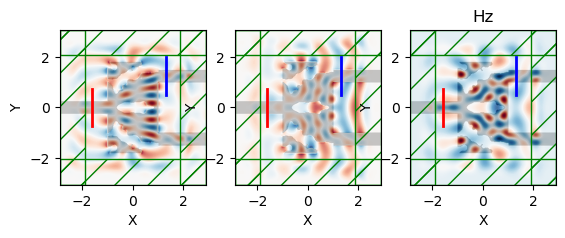

In [34]:
_, axes = plt.subplots(1,3)
sim.plot2D(fields=mp.Ex, ax=axes[0])
plt.title('Ex')
sim.plot2D(fields=mp.Ey, ax=axes[1])
plt.title('Ey')
sim.plot2D(fields=mp.Hz, ax=axes[2])
plt.title('Hz')
plt.show()

In [28]:
#debugging
import os
import numpy as np
import matplotlib.pyplot as plt
from icecream import ic
PATH = '~/scratch/nanophoto/lowfom/nodata/fields'
PATH = os.path.expanduser(PATH)

ic| f0.min(): -0.6147139150878218, f0.max(): 0.6147139150878218
ic| f1.min(): -0.5862201920114011, f1.max(): 0.5862201920114011
ic| f0.min(): -1.0657774119307353, f0.max(): 1.299933493997433
ic| f1.min(): -0.9230115798233446, f1.max(): 1.1151629425060283
ic| f0.min(): 0.0, f0.max(): 0.0
ic| f1.min(): 0.0, f1.max(): 0.0


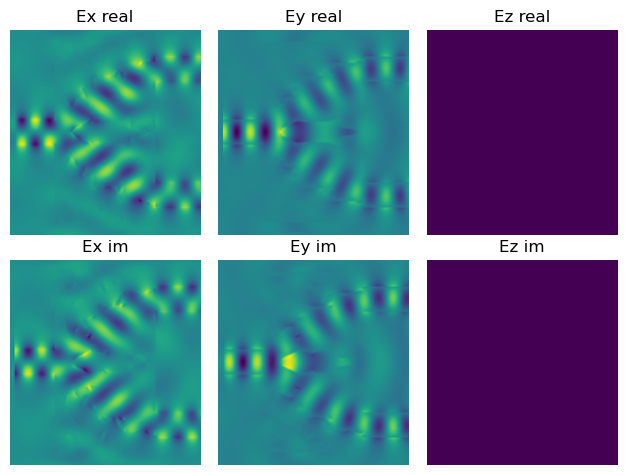

In [29]:
field = np.load(os.path.join(PATH, 'fields.npy'), mmap_mode='r')[image_idx]
names = ['Ex', 'Ey', 'Ez']
_, axes = plt.subplots(2,len(names))
for i, name in enumerate(names):
    f0 = np.real(field[...,i])
    f1 = np.imag(field[...,i])
    axes[0,i].imshow(f0.transpose())
    axes[0,i].set_title(f'{name} real')
    axes[0,i].axis('off')
    axes[1,i].imshow(f1.transpose())
    axes[1,i].axis('off')
    axes[1,i].set_title(f'{name} im')
    ic(f0.min(), f0.max())
    ic(f1.min(), f1.max())
plt.tight_layout()
plt.show()

In [30]:
# from skimage.segmentation import find_boundaries
# from icecream import ic

# def ajouter_bordures(matrice, nb_lignes_haut=52, nb_lignes_bas=52, nb_colonnes_gauche=63, nb_colonnes_droite=62):
#     hauteur, largeur = matrice.shape
#     nouvelle_hauteur = hauteur + nb_lignes_haut + nb_lignes_bas
#     nouvelle_largeur = largeur + nb_colonnes_gauche + nb_colonnes_droite
#     nouvelle_matrice = np.zeros((nouvelle_hauteur, nouvelle_largeur), dtype=matrice.dtype)
#     nouvelle_matrice[nb_lignes_haut:nb_lignes_haut + hauteur, nb_colonnes_gauche:nb_colonnes_gauche + largeur] = matrice
#     return nouvelle_matrice

# def divise_en_deux(args):
#     from math import ceil, floor
#     nombres = []
#     for x in args:
#         nombres += [int(ceil(x/2)), int(floor(x/2))]
#     return nombres
    

# field = sim.get_array(mp.Ex)
# # double = double_with_mirror(image)
# # bordures = divise_en_deux((np.array(field.shape) - np.array(double.shape)).tolist())
# # ic(bordures)

# # double = ajouter_bordures(double, *bordures)
# bd = find_boundaries(sim.get_array(mp.Dielectric))

# masque = np.ma.masked_where(bd == 0, bd)
# plt.imshow(field.transpose())  # Utilisez la colormap appropriée pour votre image de base
# plt.imshow(masque.transpose(), cmap='viridis', interpolation='none', alpha = 0.15) # interpolation='none' important pour éviter le lissage, alpha pour la transparence globale.

# _, axes = plt.subplots(2,6)
# names = ['Ex', 'Ey', 'Ez', 'Hx', 'Hy', 'Hz']
# for i, component in enumerate([mp.Ex, mp.Ey, mp.Ez, mp.Hx, mp.Hy, mp.Hz]):
#     field = sim.get_array(component=component, cmplx=True)
#     f0 = np.real(field)
#     f1 = np.imag(field)
#     axes[0,i].imshow(f0.transpose())
#     axes[0,i].set_title(f'{names[i]} real')
#     axes[0,i].axis('off')
#     axes[1,i].imshow(f1.transpose())
#     axes[1,i].axis('off')
#     axes[1,i].set_title(f'{names[i]} im')
#     ic(f0.min(), f0.max())
#     ic(f1.min(), f1.max())
# plt.tight_layout()
# plt.show()